# Set Environment

In [1]:
import copy
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Preprocessing Functions

In [2]:
def dropStartingNa(dat: pd.DataFrame) -> pd.DataFrame:
  if 'GDP(SA)' in dat.columns:
    tempData = dat.drop(columns=['GDP(SA)'])
  else:
    tempData = dat

  dropIndex = []
  i = 0
  while i < len(dat) and any(tempData.iloc[i].isna()):
      dropIndex.append(dat.index[i])
      i += 1
  return dat.drop(index=dropIndex)

In [3]:
def convertToQuarterlyMean(dat: pd.DataFrame) -> pd.DataFrame:
    return dat.groupby(dat.index.asfreq('Q')).mean()

# BEM Models

In [4]:
def hamiltonFilterDF(data: pd.DataFrame) -> pd.DataFrame:
  data = copy.deepcopy(data)
  data = data.apply(hamiltonFilterSeries)
  return data

In [5]:
def hamiltonFilterSeries(series: pd.Series) -> pd.Series:
  series = copy.deepcopy(series)
  seriesNonNa = series.dropna()
  filteredSeriesNonNa = pd.Series(data=hamilton_filter(seriesNonNa, h=3, p=2)[0], index=seriesNonNa.index, name=seriesNonNa.name)

  return filteredSeriesNonNa.reindex(series.index)

In [6]:
def hamilton_filter(data, h, p=None):
    """
    This function applies "Hamilton filter" to the data

    http://econweb.ucsd.edu/~jhamilto/hp.pdf

    Parameters
    ----------
    data : array or dataframe
    h : integer
        Time horizon that we are likely to predict incorrectly.
        Original paper recommends 2 for annual data, 8 for quarterly data,
        24 for monthly data.
    p : integer (optional)
        If supplied, it is p in the paper. Number of lags in regression.
        If not supplied, random walk process is assumed.

    Returns
    -------
    cycle : array of cyclical component
    trend : trend component

    Notes
    -----
    For seasonal data, it's desirable for p and h to be integer multiples of
    the number of obsevations in a year. E.g. for quarterly data, h = 8 and p =
    4 are recommended.

    """
    # transform data to array
    y = np.asarray(data, float)
    # sample size
    T = len(y)

    if p is not None:  # if p is supplied
        # construct X matrix of lags
        X = np.ones((T-p-h+1, p+1))
        for j in range(1, p+1):
            X[:, j] = y[p-j:T-h-j+1:1]

        # do OLS regression
        b = np.linalg.solve(X.transpose()@X, X.transpose()@y[p+h-1:T])
        # trend component (`nan` for the first p+h-1 period)
        trend = np.append(np.zeros(p+h-1)+np.nan, X@b)
        # cyclical component
        cycle = y - trend
    else:  # if p is not supplied (random walk)
        cycle = np.append(np.zeros(h)+np.nan, y[h:T] - y[0:T-h])
        trend = y - cycle
    return cycle, trend

In [7]:
def kalmanState(data: pd.DataFrame, end:str) -> np.ndarray:
  mod = DynamicFactorMQ(data, factor_orders=2)
  res = mod.fit()
  factors = copy.deepcopy(res.factors['smoothed'])
  factors.columns = ['Factor']
  factors = factors.reindex(pd.period_range(start=factors.index[0], end=pd.Period(end, freq='Q-DEC'), freq='M'))
  for i, m in enumerate(factors.index):
    if np.isnan(factors['Factor'].iloc[i]):
      # factors['Factor'].iloc[i] = res.params['L1.0->0'] * factors['Factor'].iloc[i - 1] + res.params['L2.0->0'] * factors['Factor'].iloc[i - 2]
      factors.loc[m, 'Factor'] = res.params['L1.0->0'] * factors['Factor'].iloc[i - 1] + res.params['L2.0->0'] * factors['Factor'].iloc[i - 2]
  return factors

In [8]:
def bem1(data: pd.DataFrame, end: str) -> pd.Series:
  target, Xs = copy.deepcopy(data['GDP(SA)']), copy.deepcopy(data.drop(columns=['GDP(SA)']))

  filteredXs = hamiltonFilterDF(np.log(Xs)).iloc[5:]
  factors = kalmanState(data=filteredXs, end=end)
  querterlyFactors = convertToQuarterlyMean(factors)

  logTarget = np.log(target)
  querterlyLogTarget = convertToQuarterlyMean(logTarget)
  querterlyLogTarget = querterlyLogTarget.reindex(pd.period_range(start=querterlyLogTarget.index[0], end=end, freq='Q-DEC'))

  # targetARresult = ARIMA(endog=querterlyLogTarget, order=(2,0,0), trend='ct', enforce_stationarity=False, enforce_invertibility=False).fit()
  targetARresult = ARIMA(endog=querterlyLogTarget, order=(2,0,0), trend='n', enforce_stationarity=False, enforce_invertibility=False).fit()

  uARresult = ARIMA(endog=targetARresult.resid.loc['2001Q1':], exog=querterlyFactors.loc['2001Q1':], order=(1,0,0), trend='n').fit()
  finalTargetPredict = targetARresult.predict(start='2001Q1', end=end) + uARresult.predict(start='2001Q1', end=end)

  return querterlyLogTarget.fillna(finalTargetPredict)

In [9]:
def bem2(data: pd.DataFrame, end: str) -> pd.Series:
  target, Xs = copy.deepcopy(data['GDP(SA)']), copy.deepcopy(data.drop(columns=['GDP(SA)']))

  filteredXs = hamiltonFilterDF(np.log(Xs)).iloc[5:]
  factors = kalmanState(data=filteredXs, end=end)
  querterlyFactors = convertToQuarterlyMean(factors)

  logTarget = np.log(target)
  querterlyLogTarget = convertToQuarterlyMean(logTarget)
  querterlyLogTarget = querterlyLogTarget.reindex(pd.period_range(start=querterlyLogTarget.index[0], end=end, freq='Q-DEC'))

  # targetARresult = ARIMA(endog=querterlyLogTarget.loc['2000Q3':], exog=querterlyFactors.loc['2000Q3':], order=(2,0,0), trend='ct', enforce_stationarity=False, enforce_invertibility=False).fit()
  targetARresult = ARIMA(endog=querterlyLogTarget.loc['2000Q3':], exog=querterlyFactors.loc['2000Q3':], order=(2,0,0), trend='n', enforce_stationarity=False, enforce_invertibility=False).fit()

  uARresult = ARIMA(endog=targetARresult.resid.loc['2001Q1':], order=(1,0,0), trend='n').fit()
  finalTargetPredict = targetARresult.predict(start='2001Q1', end=end) + uARresult.predict(start='2001Q1', end=end)

  return querterlyLogTarget.fillna(finalTargetPredict)

# Vintage

In [10]:
fullData = pd.read_csv('2024-01-04.csv', index_col=0)
fullData.index = pd.PeriodIndex(fullData.index, freq='M')
fullData = fullData[['GDP(SA)', '전산업생산지수(SA)', '일평균수출(실질, SA)', 'NSI']]

In [11]:
vintage_dict = dict()

In [12]:
test_dates = [x for x in fullData.index if '2016-03'>=str(x)>='2006-10' and int(str(x)[-2:])%3==0]

In [13]:
test_dates

[Period('2006-12', 'M'),
 Period('2007-03', 'M'),
 Period('2007-06', 'M'),
 Period('2007-09', 'M'),
 Period('2007-12', 'M'),
 Period('2008-03', 'M'),
 Period('2008-06', 'M'),
 Period('2008-09', 'M'),
 Period('2008-12', 'M'),
 Period('2009-03', 'M'),
 Period('2009-06', 'M'),
 Period('2009-09', 'M'),
 Period('2009-12', 'M'),
 Period('2010-03', 'M'),
 Period('2010-06', 'M'),
 Period('2010-09', 'M'),
 Period('2010-12', 'M'),
 Period('2011-03', 'M'),
 Period('2011-06', 'M'),
 Period('2011-09', 'M'),
 Period('2011-12', 'M'),
 Period('2012-03', 'M'),
 Period('2012-06', 'M'),
 Period('2012-09', 'M'),
 Period('2012-12', 'M'),
 Period('2013-03', 'M'),
 Period('2013-06', 'M'),
 Period('2013-09', 'M'),
 Period('2013-12', 'M'),
 Period('2014-03', 'M'),
 Period('2014-06', 'M'),
 Period('2014-09', 'M'),
 Period('2014-12', 'M'),
 Period('2015-03', 'M'),
 Period('2015-06', 'M'),
 Period('2015-09', 'M'),
 Period('2015-12', 'M'),
 Period('2016-03', 'M')]

In [14]:
for test_date in test_dates:
    temp_dat = copy.deepcopy(fullData)
    temp_dat = temp_dat.loc[:test_date]

    for col in ['GDP(SA)', '전산업생산지수(SA)']:
        temp_dat.loc[test_date, col] = np.nan

    vintage_dict[test_date] = temp_dat

In [15]:
vintage_dict[pd.Period('2016-03', 'M')]

,GDP(SA),전산업생산지수(SA),"일평균수출(실질, SA)",NSI
2000-01,NaN,52.5,8.575735e+05,NaN
2000-02,NaN,52.5,9.208497e+05,NaN
2000-03,220786.3,53.6,9.157984e+05,NaN
2000-04,NaN,53.5,9.982122e+05,NaN
2000-05,NaN,54.9,1.010233e+06,NaN
...,...,...,...,...
2015-11,NaN,94.0,2.052452e+06,106.13
2015-12,420167.6,94.6,1.874112e+06,101.40
2016-01,NaN,93.5,1.809522e+06,96.32
2016-02,NaN,94.7,1.876428e+06,94.67


In [16]:
predNow = pd.DataFrame(index=pd.period_range(start='2007Q1', end='2015Q4', freq='Q-DEC'), columns=['BEM1', 'BEM2'])
pred1qa = pd.DataFrame(index=pd.period_range(start='2007Q1', end='2016Q1', freq='Q-DEC'), columns=['BEM1', 'BEM2'])

In [17]:
for test_date, data in vintage_dict.items():
  now=str(test_date.asfreq('Q-DEC'))
  aqa=str(test_date.asfreq('Q-DEC') + 1)

  predNow.loc[now, 'BEM1'] = bem1(data, now).diff().iloc[-1]*100
  pred1qa.loc[aqa, 'BEM1'] = bem1(data, aqa).diff().iloc[-1]*100

  
  predNow.loc[now, 'BEM2'] = bem2(data, now).diff().iloc[-1]*100
  pred1qa.loc[aqa, 'BEM2'] = bem2(data, aqa).diff().iloc[-1]*100

c:\Users\BOK\Desktop\papers\prism\R&R\code\Q5\.venv\Lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-203.54, convergence criterion=1.3284e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'
c:\Users\BOK\Desktop\papers\prism\R&R\code\Q5\.venv\Lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-203.54, convergence criterion=1.3284e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'
c:\Users\BOK\Desktop\papers\prism\R&R\code\Q5\.venv\Lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-203.54, convergence criterion=1.3284e-06 (while specifie

In [18]:
predNow

,BEM1,BEM2
2007Q1,0.897025,1.180459
2007Q2,1.449513,1.420799
2007Q3,1.592095,1.399047
2007Q4,1.407133,1.282878
2008Q1,1.294261,1.814335
2008Q2,0.994032,1.182098
2008Q3,0.832779,0.975231
2008Q4,0.132273,0.920217
2009Q1,-0.634961,2.783055
2009Q2,2.431636,1.145798


In [19]:
# predNow.to_excel('bem_results.xlsx')

In [20]:
pred1qa.to_excel('bem_results_1qa.xlsx')

In [21]:
return

SyntaxError: 'return' outside function (3438313781.py, line 1)

# Evaluate

In [ ]:
predNow['GDP true'] = np.log(convertToQuarterlyMean(fullData['GDP(SA)'])).diff()*100

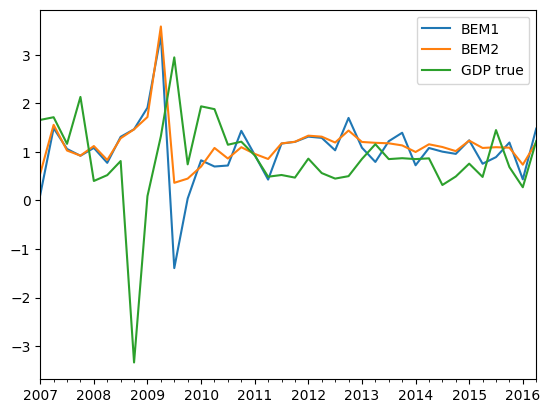

In [ ]:
predNow.plot()
None

In [ ]:
mean_absolute_error(predNow['GDP true'], predNow['BEM1'])

0.8840411252790036

In [22]:
pred1qa['GDP true'] = np.log(convertToQuarterlyMean(fullData['GDP(SA)'])).diff()*100

<Axes: >

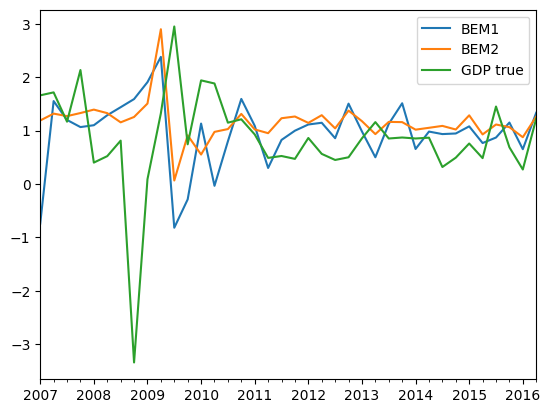

In [23]:
pred1qa.plot()

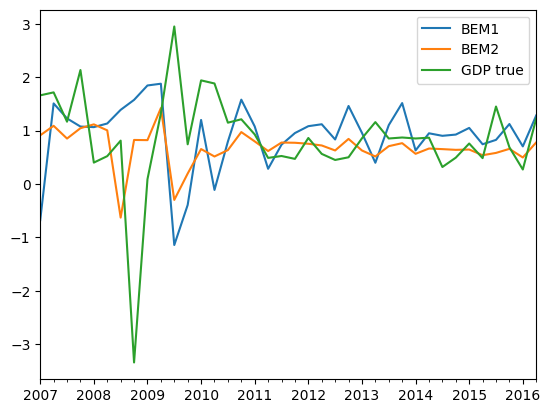

In [ ]:
pred1qa.plot()
None

# Test

In [ ]:
from google.colab import files
files.upload()

Saving 2024-01-04.csv to 2024-01-04.csv


{'2024-01-04.csv': b',GDP(SA),\xec\x88\x98\xec\xb6\x9c(NSA),\xec\x88\x98\xec\x9e\x85(NSA),\xec\x86\x8c\xeb\xb9\x84\xec\x9e\x90\xeb\xac\xbc\xea\xb0\x80\xec\xa7\x80\xec\x88\x98(NSA),NSI,\xec\xa0\x84\xec\x82\xb0\xec\x97\x85\xec\x83\x9d\xec\x82\xb0\xec\xa7\x80\xec\x88\x98(SA),\xec\x9d\xbc\xed\x8f\x89\xea\xb7\xa0\xec\x88\x98\xec\xb6\x9c(NSA),\xec\x9d\xbc\xed\x8f\x89\xea\xb7\xa0\xec\x88\x98\xec\x9e\x85(NSA),\xec\x9d\xbc\xed\x8f\x89\xea\xb7\xa0\xec\x88\x98\xec\xb6\x9c(SA),\xec\x9d\xbc\xed\x8f\x89\xea\xb7\xa0\xec\x88\x98\xec\x9e\x85(SA),\xec\x86\x8c\xeb\xb9\x84\xec\x9e\x90\xeb\xac\xbc\xea\xb0\x80\xec\xa7\x80\xec\x88\x98(SA),"\xec\x9d\xbc\xed\x8f\x89\xea\xb7\xa0\xec\x88\x98\xec\xb6\x9c(\xec\x8b\xa4\xec\xa7\x88, SA)"\r\n200001,,12162425.0,12594623.0,62.456,,52.5,511026.26050420164,529185.8403361344,536977.571058137,532463.900964831,62.6159275774485,857573.4510903143\r\n200002,,12676042.0,12023652.0,62.647,,52.5,573576.5610859728,544056.6515837103,576738.790339321,523585.471625166,62.631155775193

In [ ]:
data = pd.read_csv('2024-01-04.csv', index_col=0)

In [ ]:
data.index = pd.PeriodIndex(data.index, freq='M')

In [ ]:
data = data[['GDP(SA)', '전산업생산지수(SA)', '일평균수출(실질, SA)', 'NSI']]

In [ ]:
data

,GDP(SA),전산업생산지수(SA),"일평균수출(실질, SA)",NSI
2000-01,NaN,52.5,8.575735e+05,NaN
2000-02,NaN,52.5,9.208497e+05,NaN
2000-03,220786.3,53.6,9.157984e+05,NaN
2000-04,NaN,53.5,9.982122e+05,NaN
2000-05,NaN,54.9,1.010233e+06,NaN
...,...,...,...,...
2023-09,500277.3,113.0,2.123454e+06,100.78
2023-10,NaN,111.0,2.120541e+06,95.52
2023-11,NaN,111.6,2.145067e+06,102.34
2023-12,NaN,NaN,2.269058e+06,103.33


In [ ]:
end = '2023Q4'

In [ ]:
bem1(data, end).diff()*100

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2651: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


                                       Dynamic Factor Results                                      
Dep. Variable:     ['전산업생산지수(SA)', '일평균수출(실질, SA)', 'NSI']   No. Observations:                  284
Model:                                Dynamic Factor Model   Log Likelihood                -891.806
                                   + 1 factors in 1 blocks   AIC                           1807.612
                                     + AR(1) idiosyncratic   BIC                           1851.400
Date:                                     Tue, 09 Jan 2024   HQIC                          1825.167
Time:                                             11:22:47   EM Iterations                        2
Sample:                                         06-30-2000                                         
                                              - 01-31-2024                                         
Covariance Type:                              Not computed                                         


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2000Q1         NaN
2000Q2    1.323710
2000Q3    2.717335
2000Q4   -0.324985
2001Q1    1.218106
            ...   
2022Q4   -0.303428
2023Q1    0.329332
2023Q2    0.606808
2023Q3    0.614183
2023Q4    1.175666
Freq: Q-DEC, Name: GDP(SA), Length: 96, dtype: float64

2000Q1    220786.30000
2000Q2    223728.30000
2000Q3    229891.10000
2000Q4    229145.20000
2001Q1    231953.50000
              ...     
2022Q4    492581.20000
2023Q1    494206.10000
2023Q2    497214.10000
2023Q3    500277.30000
2023Q4    506193.59913
Freq: Q-DEC, Name: GDP(SA), Length: 96, dtype: float64

## Calculate Factors

In [ ]:
target, Xs = data['GDP(SA)'], data.drop(columns=['GDP(SA)'])

In [ ]:
target

2000-01         NaN
2000-02         NaN
2000-03    220786.3
2000-04         NaN
2000-05         NaN
             ...   
2023-09    500277.3
2023-10         NaN
2023-11         NaN
2023-12         NaN
2024-01         NaN
Freq: M, Name: GDP(SA), Length: 289, dtype: float64

In [ ]:
Xs

,전산업생산지수(SA),"일평균수출(실질, SA)",NSI
2000-01,52.5,8.575735e+05,NaN
2000-02,52.5,9.208497e+05,NaN
2000-03,53.6,9.157984e+05,NaN
2000-04,53.5,9.982122e+05,NaN
2000-05,54.9,1.010233e+06,NaN
...,...,...,...
2023-09,113.0,2.123454e+06,100.78
2023-10,111.0,2.120541e+06,95.52
2023-11,111.6,2.145067e+06,102.34
2023-12,NaN,2.269058e+06,103.33


In [ ]:
filteredObserved = hamiltonFilterDF(np.log(Xs)).iloc[5:]
filteredObserved

,전산업생산지수(SA),"일평균수출(실질, SA)",NSI
2000-06,0.014985,0.046654,NaN
2000-07,0.023870,0.008494,NaN
2000-08,-0.000465,-0.035211,NaN
2000-09,-0.016797,0.011769,NaN
2000-10,-0.028051,-0.078254,NaN
...,...,...,...
2023-09,0.018354,0.014412,0.003528
2023-10,0.007154,0.038830,-0.053081
2023-11,-0.001541,0.044678,0.031473
2023-12,NaN,0.066546,0.032516


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*a

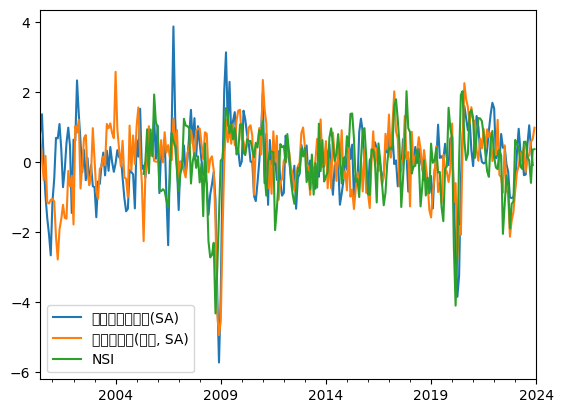

In [ ]:
(filteredObserved / filteredObserved.std()).plot()

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*a

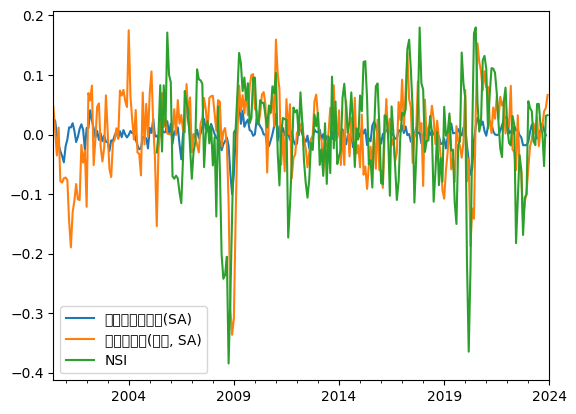

In [ ]:
filteredObserved.plot()

In [ ]:
factors = kalmanState(data=filteredObserved, end=end)
factors

                                       Dynamic Factor Results                                      
Dep. Variable:     ['전산업생산지수(SA)', '일평균수출(실질, SA)', 'NSI']   No. Observations:                  284
Model:                                Dynamic Factor Model   Log Likelihood                -891.806
                                   + 1 factors in 1 blocks   AIC                           1807.612
                                     + AR(1) idiosyncratic   BIC                           1851.400
Date:                                     Tue, 09 Jan 2024   HQIC                          1825.167
Time:                                             10:46:49   EM Iterations                        2
Sample:                                         06-30-2000                                         
                                              - 01-31-2024                                         
Covariance Type:                              Not computed                                         


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2651: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


,Factor
2000-06,-1.216876
2000-07,-0.999711
2000-08,0.073109
2000-09,0.768430
2000-10,1.812545
...,...
2023-08,-0.380449
2023-09,-0.652252
2023-10,-0.427956
2023-11,-0.467014


In [ ]:
querterlyFactors = convertToQuarterlyMean(factors)
querterlyFactors

,Factor
2000Q2,-1.216876
2000Q3,-0.052724
2000Q4,2.177082
2001Q1,1.077022
2001Q2,0.536805
...,...
2022Q4,1.794663
2023Q1,-0.042949
2023Q2,-0.198055
2023Q3,-0.337082


In [ ]:
logTarget = np.log(target)
querterlyLogTarget = convertToQuarterlyMean(logTarget)
querterlyLogTarget = querterlyLogTarget.reindex(pd.period_range(start='2000Q1', end=end, freq='Q-DEC'))

In [ ]:
querterlyLogTarget

2000Q1    12.304951
2000Q2    12.318188
2000Q3    12.345361
2000Q4    12.342111
2001Q1    12.354292
            ...    
2022Q4    13.107415
2023Q1    13.110708
2023Q2    13.116776
2023Q3    13.122918
2023Q4          NaN
Freq: Q-DEC, Name: GDP(SA), Length: 96, dtype: float64

In [ ]:
targetARresult = ARIMA(endog=querterlyLogTarget, order=(2,0,0), trend='ct', enforce_stationarity=False, enforce_invertibility=False).fit()
targetARresult.summary()
# uARresult = ARIMA(endog=targetARresult.resid.loc['2001Q1':], exog=querterlyFactors.loc['2001Q1':], order=(1,0,0), trend='n').fit()
# finalTargetPredict = targetARresult.predict(start='2016Q1', end=end) + uARresult.predict(start='2016Q1', end=end)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                GDP(SA)   No. Observations:                   96
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 308.506
Date:                Tue, 09 Jan 2024   AIC                           -607.011
Time:                        10:56:14   BIC                           -594.295
Sample:                    03-31-2000   HQIC                          -601.875
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5163      0.134     93.672      0.000      12.254      12.778
x1             0.0065      0.002      4.153      0.000       0.003       0.010
ar.L1          1.0851      0.089     12.129      0.000       0.910       1.260
ar.L2         -0.1309      0.093     -1.412      0.158      -0.313       0.051
sigma2      7.686e-05   7.64e-06     10.064      0.000    6.19e-05    9.18e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               219.77
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                            -1.78
Prob(H) (two-sided):                  0.41   Kurtosis:                         9.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

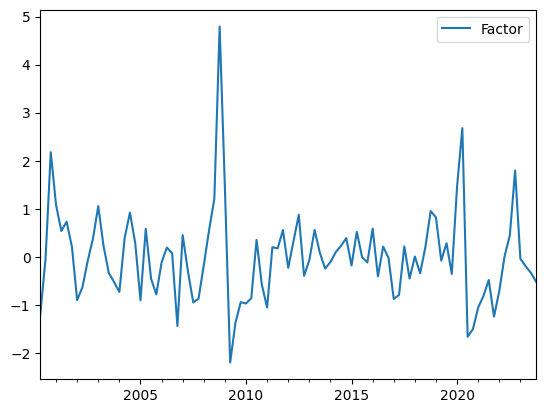

In [ ]:
querterlyFactors.plot()

In [ ]:
uARresult = ARIMA(endog=targetARresult.resid.loc['2001Q1':], exog=querterlyFactors.loc['2001Q1':], order=(1,0,0), trend='n').fit()

In [ ]:
uARresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   92
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 343.863
Date:                Tue, 09 Jan 2024   AIC                           -681.725
Time:                        10:58:33   BIC                           -674.160
Sample:                    03-31-2001   HQIC                          -678.672
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Factor        -0.0067      0.000    -15.190      0.000      -0.008      -0.006
ar.L1         -0.3309      0.097     -3.410      0.001      -0.521      -0.141
sigma2      3.051e-05   4.71e-06      6.482      0.000    2.13e-05    3.97e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.72
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.84
Prob(H) (two-sided):                  0.58   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
finalTargetPredict = targetARresult.predict(start='2016Q1', end=end) + uARresult.predict(start='2016Q1', end=end)

In [ ]:
finalTargetPredict

2016Q1    12.950722
2016Q2    12.959245
2016Q3    12.967238
2016Q4    12.973581
2017Q1    12.985190
2017Q2    12.995453
2017Q3    12.996517
2017Q4    13.010924
2018Q1    13.010117
2018Q2    13.019908
2018Q3    13.025528
2018Q4    13.025340
2019Q1    13.030920
2019Q2    13.038357
2019Q3    13.046079
2019Q4    13.055618
2020Q1    13.054742
2020Q2    13.035810
2020Q3    13.036228
2020Q4    13.056066
2021Q1    13.069707
2021Q2    13.082900
2021Q3    13.090602
2021Q4    13.097583
2022Q1    13.106453
2022Q2    13.108871
2022Q3    13.111245
2022Q4    13.104773
2023Q1    13.112467
2023Q2    13.119697
2023Q3    13.126837
2023Q4    13.134674
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [ ]:
hamiltonFilter(log(Xs))

,전산업생산지수(SA),"일평균수출(실질, SA)",NSI
2000-01,NaN,NaN,NaN
2000-02,NaN,NaN,NaN
2000-03,NaN,NaN,NaN
2000-04,NaN,NaN,NaN
2000-05,NaN,NaN,NaN
...,...,...,...
2023-09,NaN,NaN,NaN
2023-10,NaN,NaN,NaN
2023-11,NaN,NaN,NaN
2023-12,NaN,NaN,NaN


### Hamilton Filter

In [ ]:
filteredObserved = hamiltonFilter(log(Xs)).iloc[3:]

In [ ]:
filteredObserved

,전산업생산지수(SA),"일평균수출(실질, SA)",NSI
2000-04,1.886848,15.244648,NaN
2000-05,4.470018,9.273407,NaN
2000-06,2.760065,7.740964,NaN
2000-07,4.029849,3.315677,NaN
2000-08,1.086967,-0.824239,NaN
...,...,...,...
2023-03,1.998250,-1.717768,12.157326
2023-04,0.823803,1.896752,1.313439
2023-05,0.995033,0.555171,-0.989699
2023-06,0.009982,3.198122,7.633550


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


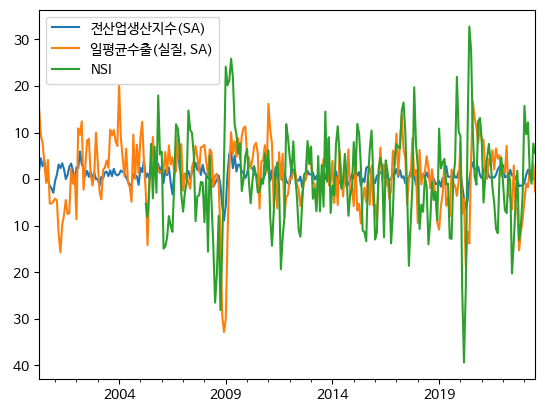

In [ ]:
filteredObserved.plot()

### Kalman

In [ ]:
def kalmanState(data: pd.DataFrame, end:str) -> np.ndarray:
  mod = DynamicFactorMQ(data, factor_orders=2)
  res = mod.fit()
  # print(res.summary())
  factors = copy.deepcopy(res.factors['smoothed'])
  factors.columns = ['Factor']
  factors = factors.reindex(pd.period_range(start=factors.index[0], end=pd.Period(end, freq='Q-DEC'), freq='M'))
  for i in range(len(factors)):
    if np.isnan(factors['Factor'].iloc[i]):
      factors['Factor'].iloc[i] = res.params['L1.0->0'] * factors['Factor'].iloc[i - 1] + res.params['L2.0->0'] * factors['Factor'].iloc[i - 2]
  return factors

In [ ]:
factors = kalmanState(data=filteredObserved, end=end)

                                       Dynamic Factor Results                                      
Dep. Variable:     ['전산업생산지수(SA)', '일평균수출(실질, SA)', 'NSI']   No. Observations:                  280
Model:                                Dynamic Factor Model   Log Likelihood                -910.780
                                   + 1 factors in 1 blocks   AIC                           1845.559
                                     + AR(1) idiosyncratic   BIC                           1889.177
Date:                                     Fri, 04 Aug 2023   HQIC                          1863.055
Time:                                             00:49:45   EM Iterations                       41
Sample:                                         04-30-2000                                         
                                              - 07-31-2023                                         
Covariance Type:                              Not computed                                         


In [ ]:
factors

,Factor
2000-04,-2.539684
2000-05,-2.715638
2000-06,-2.062890
2000-07,-1.321023
2000-08,-0.279419
...,...
2023-08,0.328196
2023-09,0.221708
2023-10,0.088379
2023-11,-0.013765


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


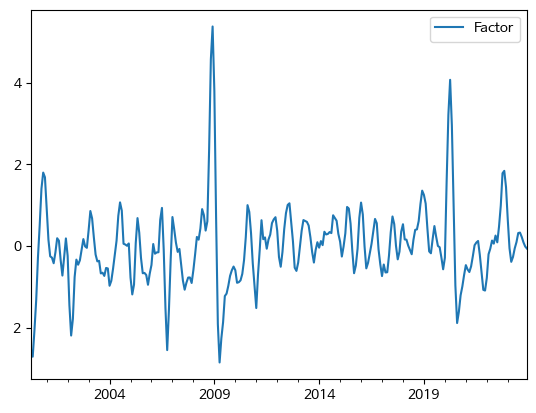

In [ ]:
factors.plot()

In [ ]:
querterlyFactors = convertToQuarterlyMean(factors)

In [ ]:
querterlyFactors

,Factor
2000Q2,-2.439404
2000Q3,-0.363265
2000Q4,1.629845
2001Q1,0.270284
2001Q2,-0.288249
...,...
2022Q4,1.690615
2023Q1,0.067285
2023Q2,-0.076691
2023Q3,0.289052


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


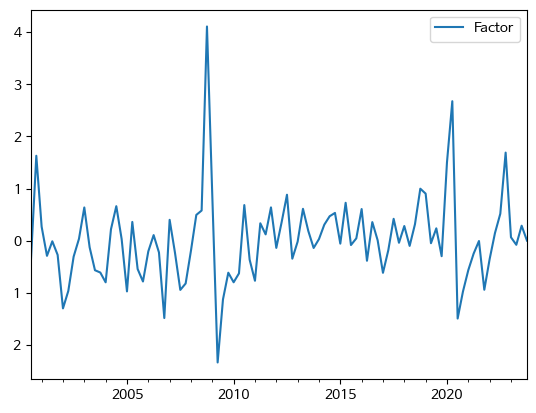

In [ ]:
querterlyFactors.loc['2000Q3':].plot()

## BEM

In [ ]:
target

,GDP(SA)
2000-01,NaN
2000-02,NaN
2000-03,220786.3
2000-04,NaN
2000-05,NaN
...,...
2023-03,494206.1
2023-04,NaN
2023-05,NaN
2023-06,497114.1


In [ ]:
logTarget = log(target)

In [ ]:
querterlyLogTarget = convertToQuarterlyMean(logTarget)

In [ ]:
querterlyLogTarget = querterlyLogTarget.reindex(pd.period_range(start=factors.index[0], end=end, freq='Q-DEC'))

In [ ]:
querterlyLogTarget

,GDP(SA)
2000Q2,1231.818765
2000Q3,1234.536100
2000Q4,1234.211114
2001Q1,1235.429220
2001Q2,1236.719738
...,...
2022Q4,1310.741460
2023Q1,1311.070792
2023Q2,1311.657486
2023Q3,NaN


### BEM1

#### GDP AR(2)

In [ ]:
targetARresult = ARIMA(endog=querterlyLogTarget.loc['2000Q3':], order=(2,0,0), trend='ct', enforce_stationarity=False, enforce_invertibility=False).fit()

In [ ]:
targetARresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                GDP(SA)   No. Observations:                   94
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -113.588
Date:                Fri, 04 Aug 2023   AIC                            237.176
Time:                        00:50:18   BIC                            249.785
Sample:                    09-30-2000   HQIC                           242.265
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1250.3412     10.250    121.989      0.000    1230.252    1270.430
x1             0.6866      0.133      5.176      0.000       0.427       0.947
ar.L1          1.1228      0.088     12.706      0.000       0.950       1.296
ar.L2         -0.1788      0.104     -1.722      0.085      -0.382       0.025
sigma2         0.7307      0.078      9.386      0.000       0.578       0.883
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               256.07
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -1.80
Prob(H) (two-sided):                  0.08   Kurtosis:                        10.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
targetARresult.predict(start='2023Q2', end=end)

2023Q2    1311.791508
2023Q3    1312.429804
2023Q4    1313.230513
Freq: Q-DEC, Name: predicted_mean, dtype: float64

#### U_t

In [ ]:
targetARresult.resid

2000Q3   -16.491667
2000Q4     1.014139
2001Q1    -0.266935
2001Q2    -0.440664
2001Q3    -0.369180
            ...    
2022Q4    -0.931623
2023Q1    -0.258269
2023Q2    -0.134022
2023Q3          NaN
2023Q4          NaN
Freq: Q-DEC, Length: 94, dtype: float64

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


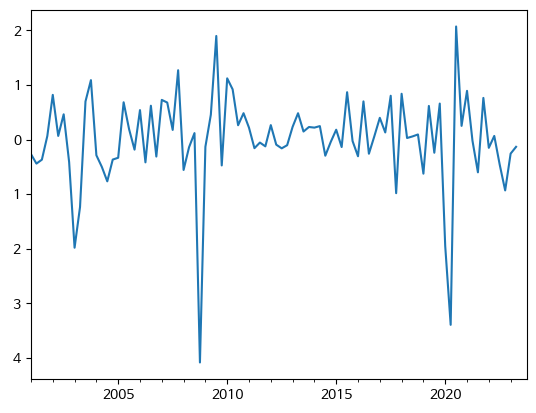

In [ ]:
targetARresult.resid.loc['2001Q1':].plot()

In [ ]:
uARresult = ARIMA(endog=targetARresult.resid.loc['2001Q1':], exog=querterlyFactors.loc['2001Q1':], order=(1,0,0), trend='n').fit()

In [ ]:
uARresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   92
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -80.808
Date:                Fri, 04 Aug 2023   AIC                            167.616
Time:                        00:50:27   BIC                            175.182
Sample:                    03-31-2001   HQIC                           170.670
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Factor        -0.7209      0.046    -15.768      0.000      -0.810      -0.631
ar.L1         -0.2248      0.091     -2.468      0.014      -0.403      -0.046
sigma2         0.3525      0.054      6.556      0.000       0.247       0.458
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 9.78
Prob(Q):                              0.82   Prob(JB):                         0.01
Heteroskedasticity (H):               0.60   Skew:                            -0.76
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
uARresult.predict(start='2023Q2', end=end)

2023Q2    0.102444
2023Q3   -0.165814
2023Q4   -0.012090
Freq: Q-DEC, Name: predicted_mean, dtype: float64

#### Final result

In [ ]:
finalTargetPredict = targetARresult.predict(start='2023Q2', end=end) + uARresult.predict(start='2023Q2', end=end)

In [ ]:
finalTargetPredict

2023Q2    1311.893952
2023Q3    1312.263990
2023Q4    1313.218422
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [ ]:
np.exp(finalTargetPredict/100)

2023Q2    498290.999139
2023Q3    500138.279542
2023Q4    504934.613824
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [ ]:
finalTargetPredict.loc['2023Q2'] - querterlyLogTarget.loc['2023Q1']

GDP(SA)    0.823161
Name: 2023Q1, dtype: float64

In [ ]:
finalTargetPredict.loc['2023Q3'] - querterlyLogTarget.loc['2023Q2']

GDP(SA)    0.606504
Name: 2023Q2, dtype: float64

In [ ]:
finalTargetPredict.loc['2023Q4'] - finalTargetPredict.loc['2023Q3']

0.9544324046044039

### BEM2

#### GDP AR(2) + factor exog

In [ ]:
targetARresult = ARIMA(endog=querterlyLogTarget.loc['2000Q3':], exog=querterlyFactors.loc['2000Q3':], order=(2,0,0), trend='ct', enforce_stationarity=False, enforce_invertibility=False).fit()

In [ ]:
targetARresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                GDP(SA)   No. Observations:                   94
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -106.564
Date:                Fri, 04 Aug 2023   AIC                            225.127
Time:                        00:51:46   BIC                            240.258
Sample:                    09-30-2000   HQIC                           231.234
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1250.4760     10.499    119.103      0.000    1229.898    1271.054
drift          0.6850      0.132      5.179      0.000       0.426       0.944
Factor        -0.3042      0.062     -4.932      0.000      -0.425      -0.183
ar.L1          1.2068      0.102     11.860      0.000       1.007       1.406
ar.L2         -0.2550      0.103     -2.480      0.013      -0.456      -0.054
sigma2         0.6252      0.068      9.219      0.000       0.492       0.758
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                73.01
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.90
Prob(H) (two-sided):                  0.60   Kurtosis:                         6.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
targetARresult.predict(start='2023Q2', end=end)

2023Q2    1311.666010
2023Q3    1312.284871
2023Q4    1313.157742
Freq: Q-DEC, Name: predicted_mean, dtype: float64

#### U_t

In [ ]:
targetARresult.resid

2000Q3   -16.735465
2000Q4     3.058027
2001Q1    -0.602940
2001Q2    -0.414466
2001Q3    -0.168733
            ...    
2022Q4    -0.557234
2023Q1    -0.730534
2023Q2    -0.008525
2023Q3          NaN
2023Q4          NaN
Freq: Q-DEC, Length: 94, dtype: float64

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


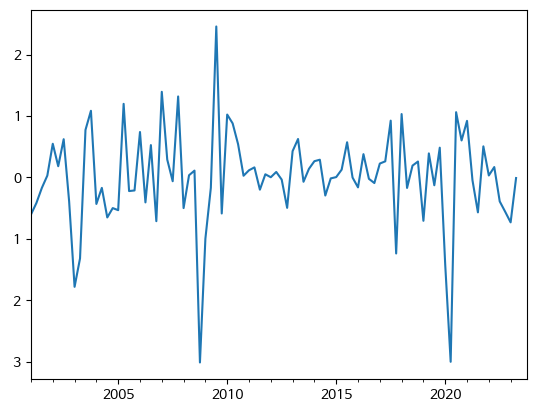

In [ ]:
targetARresult.resid.loc['2001Q1':].plot()

In [ ]:
uARresult = ARIMA(endog=targetARresult.resid.loc['2001Q1':], order=(2,0,0), trend='n').fit()

In [ ]:
uARresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   92
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -106.239
Date:                Fri, 04 Aug 2023   AIC                            218.477
Time:                        00:51:52   BIC                            226.042
Sample:                    03-31-2001   HQIC                           221.530
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0190      0.088      0.217      0.829      -0.153       0.191
ar.L2         -0.0828      0.115     -0.718      0.473      -0.309       0.143
sigma2         0.6205      0.060     10.385      0.000       0.503       0.738
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                65.78
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.88
Prob(H) (two-sided):                  0.60   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
uARresult.predict(start='2023Q2', end=end)

2023Q2    0.032268
2023Q3    0.060343
2023Q4    0.001853
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [ ]:
uARresult.resid

2001Q1   -0.602940
2001Q2   -0.403884
2001Q3   -0.210794
2001Q4   -0.000127
2002Q1    0.534853
            ...   
2022Q4   -0.535755
2023Q1   -0.752161
2023Q2   -0.040793
2023Q3         NaN
2023Q4         NaN
Freq: Q-DEC, Length: 92, dtype: float64

#### Final result

In [ ]:
finalTargetPredict = targetARresult.predict(start='2023Q2', end=end) + uARresult.predict(start='2023Q2', end=end)

In [ ]:
finalTargetPredict

2023Q2    1311.698278
2023Q3    1312.345214
2023Q4    1313.159595
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [ ]:
np.exp(finalTargetPredict/100)

2023Q2    497316.927623
2023Q3    500544.678122
2023Q4    504637.662183
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [ ]:
finalTargetPredict.loc['2023Q2'] - querterlyLogTarget.loc['2023Q1']

GDP(SA)    0.627487
Name: 2023Q1, dtype: float64

In [ ]:
finalTargetPredict.loc['2023Q3'] - finalTargetPredict.loc['2023Q2']

0.6469357549842698

In [ ]:
finalTargetPredict.loc['2023Q4'] - finalTargetPredict.loc['2023Q3']

0.8143809373493696